# Audio Multilabel Classification with PyTorch

This notebook implements various models for multilabel classification of audio recordings based on extracted features. The dataset contains features from audio recordings with five possible labels: Prolongation, Block, WordRep, SoundRep, and Interjection.

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Data Loading and Preprocessing

In [21]:
# Load the data
def load_data(file_path):
    # # Read the data
    # columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 
    #            '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
    #            '30', '31', '32', '33', 'filename', 'Prolongation', 'Block', 'WordRep', 'SoundRep', 'Interjection']
    
    data = pd.read_csv(file_path)
    data = data.drop(columns=["filename"])
    # data = data.drop(0)
    return data

# If you have the data loaded directly from the paste.txt file, use this:
# Assuming the data is in a file called 'paste.txt'
data = load_data('stuttering_features_onehot.csv')

# Display the first few rows to verify
data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,Prolongation,Block,WordRep,SoundRep,Interjection
0,-442.655062,82.724244,32.510052,44.232087,18.321268,3.111437,0.799692,-0.981469,-2.913806,-7.303000,...,16.161962,16.492496,18.188813,0.033141,0.048154,0,0,0,1,0
1,-383.271451,125.389931,19.027966,26.461583,-2.993029,4.459939,-5.893262,-16.496688,-1.480589,4.120423,...,19.887345,19.245310,17.884317,0.051051,0.057251,1,0,0,0,0
2,-343.983174,131.734272,-19.472561,8.472145,3.213081,-8.785491,-10.507480,-12.514026,0.956805,4.778186,...,22.541250,18.619617,18.808524,0.060152,0.091253,1,0,1,0,1
3,-523.418363,89.556970,37.066863,28.870445,19.063610,11.589438,1.433107,0.096861,2.284927,0.274932,...,15.681043,15.241272,16.988916,0.032123,0.021500,0,1,0,0,0
4,-384.840189,113.107955,13.179963,11.885506,-8.988784,9.504852,4.402413,-22.363881,-6.558437,1.043188,...,20.655689,20.696548,17.941130,0.047156,0.077362,0,0,0,1,0


0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
10              float64
11              float64
12              float64
13              float64
14              float64
15              float64
16              float64
17              float64
18              float64
19              float64
20              float64
21              float64
22              float64
23              float64
24              float64
25              float64
26              float64
27              float64
28              float64
29              float64
30              float64
31              float64
32              float64
33              float64
Prolongation     object
Block            object
WordRep          object
SoundRep         object
Interjection     object
dtype: object


In [22]:
# Separate features and labels
# Assuming columns 0-33 are features and the last 5 columns are labels
feature_cols = [str(i) for i in range(34)]
label_cols = ['Prolongation', 'Block', 'WordRep', 'SoundRep', 'Interjection']

X = data[feature_cols].values
y = data[label_cols].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check data shapes
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape: {X_test_scaled.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (17444, 34)
Testing features shape: (4361, 34)
Training labels shape: (17444, 5)
Testing labels shape: (4361, 5)


In [18]:
# Get data types of all columns
# Check the type of your labels
print(type(y_train))
print(y_train.dtype)  # If it's a NumPy array
print(y_train[:5])    # See the first few labels

<class 'numpy.ndarray'>
object
[['0' '0' '1' '0' '1']
 ['1' '0' '0' '0' '0']
 [1 1 0 0 0]
 ['1' '1' '0' '0' '1']
 ['0' '0' '1' '1' '0']]


In [24]:
# Method 1: Using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

ValueError: y should be a 1d array, got an array of shape (17444, 5) instead.

## 2. Custom PyTorch Dataset and DataLoader

In [25]:
# Create a custom PyTorch Dataset
class AudioFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataset objects
train_dataset = AudioFeatureDataset(X_train_scaled, y_train)
test_dataset = AudioFeatureDataset(X_test_scaled, y_test)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 3. Custom PyTorch Models

In [26]:
# Simple feed-forward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Deep neural network with dropout for better regularization
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

## 4. Training and Evaluation Functions for PyTorch Models

In [27]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    return train_losses

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            
            # Convert outputs to binary predictions (threshold = 0.5)
            preds = (outputs > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate batch predictions
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    # Calculate per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'per_class_f1': per_class_f1,
        'test_loss': avg_test_loss,
        'predictions': all_preds,
        'true_labels': all_labels
    }

## 5. Training PyTorch Models

In [28]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters
input_size = X_train_scaled.shape[1]  # Number of features
hidden_size = 64
output_size = y_train.shape[1]  # Number of labels
learning_rate = 0.001
num_epochs = 50

# Initialize models
simple_nn = SimpleNN(input_size, hidden_size, output_size).to(device)
deep_nn = DeepNN(input_size, hidden_size, output_size).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
simple_optimizer = optim.Adam(simple_nn.parameters(), lr=learning_rate)
deep_optimizer = optim.Adam(deep_nn.parameters(), lr=learning_rate)

# Train the simple neural network
print("Training Simple Neural Network...")
simple_losses = train_model(simple_nn, train_loader, criterion, simple_optimizer, device, num_epochs)

# Train the deep neural network
print("\nTraining Deep Neural Network...")
deep_losses = train_model(deep_nn, train_loader, criterion, deep_optimizer, device, num_epochs)

Using device: cpu
Training Simple Neural Network...
Epoch 1/50, Loss: 0.5811
Epoch 10/50, Loss: 0.5429
Epoch 20/50, Loss: 0.5303
Epoch 30/50, Loss: 0.5221
Epoch 40/50, Loss: 0.5167
Epoch 50/50, Loss: 0.5127

Training Deep Neural Network...
Epoch 1/50, Loss: 0.5933
Epoch 10/50, Loss: 0.5762
Epoch 20/50, Loss: 0.5720
Epoch 30/50, Loss: 0.5710
Epoch 40/50, Loss: 0.5684
Epoch 50/50, Loss: 0.5683


## 6. Evaluate PyTorch Models

In [29]:
# Evaluate the models
print("Evaluating Simple Neural Network...")
simple_metrics = evaluate_model(simple_nn, test_loader, criterion, device)

print("\nEvaluating Deep Neural Network...")
deep_metrics = evaluate_model(deep_nn, test_loader, criterion, device)

# Print metrics for PyTorch models
print("\nSimple NN Metrics:")
print(f"Accuracy: {simple_metrics['accuracy']:.4f}")
print(f"Precision: {simple_metrics['precision']:.4f}")
print(f"Recall: {simple_metrics['recall']:.4f}")
print(f"F1 Score: {simple_metrics['f1']:.4f}")
print(f"Test Loss: {simple_metrics['test_loss']:.4f}")

print("\nDeep NN Metrics:")
print(f"Accuracy: {deep_metrics['accuracy']:.4f}")
print(f"Precision: {deep_metrics['precision']:.4f}")
print(f"Recall: {deep_metrics['recall']:.4f}")
print(f"F1 Score: {deep_metrics['f1']:.4f}")
print(f"Test Loss: {deep_metrics['test_loss']:.4f}")

# Compare per-class metrics for the Deep NN
label_names = ['Prolongation', 'Block', 'WordRep', 'SoundRep', 'Interjection']
print("\nPer-Class Metrics for Deep NN:")
for i, label in enumerate(label_names):
    print(f"{label}:")
    print(f"  Precision: {deep_metrics['per_class_precision'][i]:.4f}")
    print(f"  Recall: {deep_metrics['per_class_recall'][i]:.4f}")
    print(f"  F1 Score: {deep_metrics['per_class_f1'][i]:.4f}")

Evaluating Simple Neural Network...

Evaluating Deep Neural Network...

Simple NN Metrics:
Accuracy: 0.7026
Precision: 0.3161
Recall: 0.2493
F1 Score: 0.2585
Test Loss: 0.5911

Deep NN Metrics:
Accuracy: 0.7092
Precision: 0.1443
Recall: 0.0890
F1 Score: 0.1032
Test Loss: 0.5683

Per-Class Metrics for Deep NN:
Prolongation:
  Precision: 0.6591
  Recall: 0.0447
  F1 Score: 0.0837
Block:
  Precision: 0.5714
  Recall: 0.2212
  F1 Score: 0.3189
WordRep:
  Precision: 0.2941
  Recall: 0.0062
  F1 Score: 0.0120
SoundRep:
  Precision: 0.6609
  Recall: 0.0758
  F1 Score: 0.1361
Interjection:
  Precision: 0.6559
  Recall: 0.1147
  F1 Score: 0.1952


## 7. Implement and Evaluate Scikit-learn Models for Comparison

In [30]:
# Function to train and evaluate a scikit-learn model
def train_evaluate_sklearn_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
    precision = precision_score(y_test, y_pred, average='samples', zero_division=0)
    recall = recall_score(y_test, y_pred, average='samples', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='samples', zero_division=0)
    
    # Calculate per-class metrics
    per_class_precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    per_class_recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    per_class_f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'per_class_f1': per_class_f1,
        'predictions': y_pred,
        'true_labels': y_test
    }

# Initialize scikit-learn models
# 1. Random Forest
print("Training Random Forest...")
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_metrics = train_evaluate_sklearn_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

# 2. Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=100, random_state=42))
gb_metrics = train_evaluate_sklearn_model(gb_model, X_train_scaled, y_train, X_test_scaled, y_test)

# 3. Support Vector Machine
print("\nTraining SVM...")
svm_model = MultiOutputClassifier(SVC(probability=True, random_state=42))
svm_metrics = train_evaluate_sklearn_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test)

# 4. Multi-layer Perceptron (MLP)
print("\nTraining MLP...")
mlp_model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42))
mlp_metrics = train_evaluate_sklearn_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test)

Training Random Forest...

Training Gradient Boosting...

Training SVM...

Training MLP...


In [31]:
# Print metrics for scikit-learn models
print("\nRandom Forest Metrics:")
print(f"Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"Precision: {rf_metrics['precision']:.4f}")
print(f"Recall: {rf_metrics['recall']:.4f}")
print(f"F1 Score: {rf_metrics['f1']:.4f}")

print("\nGradient Boosting Metrics:")
print(f"Accuracy: {gb_metrics['accuracy']:.4f}")
print(f"Precision: {gb_metrics['precision']:.4f}")
print(f"Recall: {gb_metrics['recall']:.4f}")
print(f"F1 Score: {gb_metrics['f1']:.4f}")

print("\nSVM Metrics:")
print(f"Accuracy: {svm_metrics['accuracy']:.4f}")
print(f"Precision: {svm_metrics['precision']:.4f}")
print(f"Recall: {svm_metrics['recall']:.4f}")
print(f"F1 Score: {svm_metrics['f1']:.4f}")

print("\nMLP Metrics:")
print(f"Accuracy: {mlp_metrics['accuracy']:.4f}")
print(f"Precision: {mlp_metrics['precision']:.4f}")
print(f"Recall: {mlp_metrics['recall']:.4f}")
print(f"F1 Score: {mlp_metrics['f1']:.4f}")


Random Forest Metrics:
Accuracy: 0.7109
Precision: 0.2145
Recall: 0.1398
F1 Score: 0.1593

Gradient Boosting Metrics:
Accuracy: 0.7075
Precision: 0.1666
Recall: 0.1017
F1 Score: 0.1190

SVM Metrics:
Accuracy: 0.7172
Precision: 0.2137
Recall: 0.1317
F1 Score: 0.1536

MLP Metrics:
Accuracy: 0.6537
Precision: 0.3405
Recall: 0.3334
F1 Score: 0.3079


## 8. Compare All Models

In [32]:
# Collect all model metrics for comparison
model_names = ['Simple NN', 'Deep NN', 'Random Forest', 'Gradient Boosting', 'SVM', 'MLP']
metrics = [simple_metrics, deep_metrics, rf_metrics, gb_metrics, svm_metrics, mlp_metrics]

# Create comparison dataframe
comparison_data = {
    'Model': model_names,
    'Accuracy': [m['accuracy'] for m in metrics],
    'Precision': [m['precision'] for m in metrics],
    'Recall': [m['recall'] for m in metrics],
    'F1 Score': [m['f1'] for m in metrics]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
comparison_df

Model Comparison:


,Model,Accuracy,Precision,Recall,F1 Score
0,Simple NN,0.702637,0.316067,0.249316,0.258509
1,Deep NN,0.709195,0.144348,0.088955,0.103248
2,Random Forest,0.710938,0.214515,0.139834,0.159330
3,Gradient Boosting,0.707452,0.166628,0.101720,0.119000
4,SVM,0.717175,0.213693,0.131698,0.153564
5,MLP,0.653703,0.340457,0.333383,0.307880


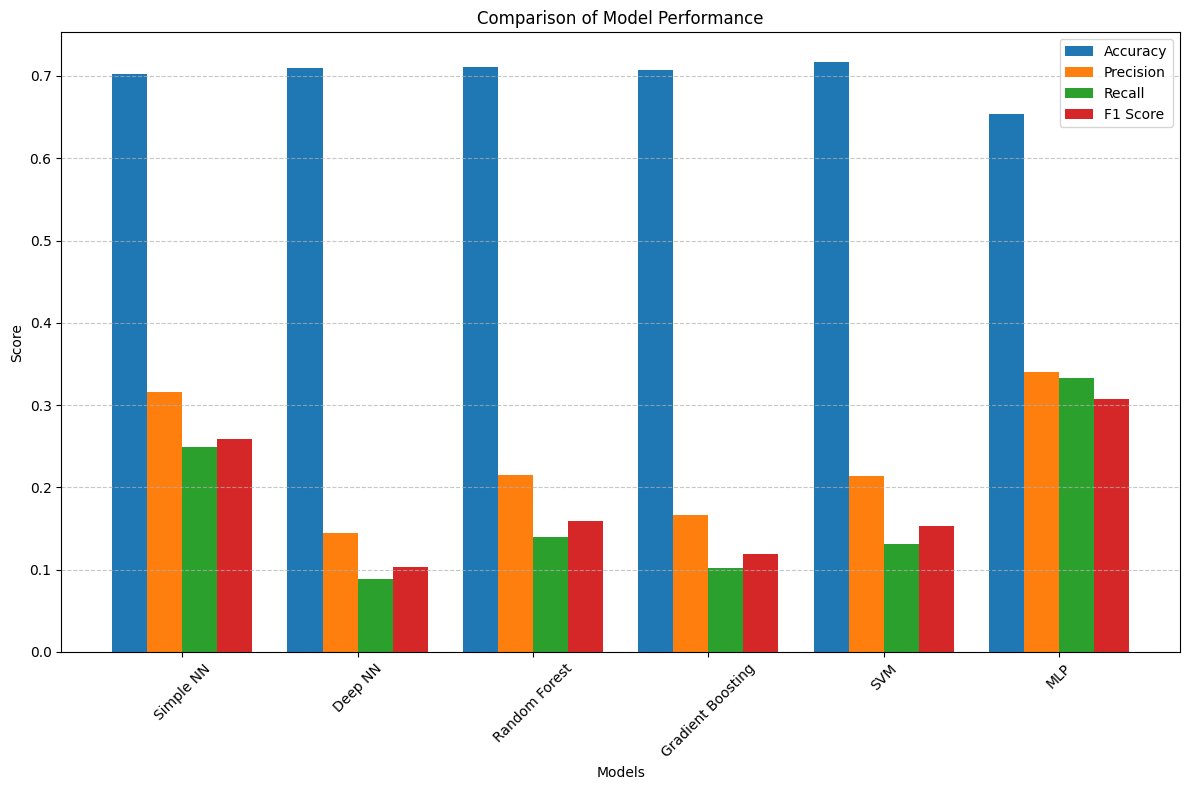

In [33]:
# Visualize the comparison
plt.figure(figsize=(12, 8))

# Create a bar chart for each metric
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(model_names))
width = 0.2
offsets = np.arange(-1.5, 2.5) * width

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + offsets[i], comparison_df[metric], width=width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 9. Per-class Performance Analysis

In [34]:
# Analyze per-class performance for the best model
# Assuming Deep NN is one of the best models (you can change this based on results)
best_model_metrics = deep_metrics
best_model_name = "Deep NN"

# Create per-class comparison dataframe
per_class_data = {
    'Label': label_names,
    'Precision': best_model_metrics['per_class_precision'],
    'Recall': best_model_metrics['per_class_recall'],
    'F1 Score': best_model_metrics['per_class_f1']
}

per_class_df = pd.DataFrame(per_class_data)
print(f"Per-class Performance for {best_model_name}:")
per_class_df

Per-class Performance for Deep NN:


,Label,Precision,Recall,F1 Score
0,Prolongation,0.659091,0.044684,0.083694
1,Block,0.571429,0.221159,0.318896
2,WordRep,0.294118,0.006150,0.012048
3,SoundRep,0.660870,0.075848,0.136079
4,Interjection,0.655914,0.114662,0.195200
